# Classificação de doenças de plantas

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Importando dependências


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Criando Constantes

In [ ]:
BATCH_TAM = 64
IMG_TAM = 256
CANAIS=3
EPOCHS=50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importar dados no dataset tensorflow


In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    f"/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMG_TAM,IMG_TAM),
    batch_size=BATCH_TAM
)

Found 20638 files belonging to 15 classes.


In [ ]:
nome_classes = dataset.class_names
nome_classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
for img_batch, labels_batch in dataset.take(1):
    print(img_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[ 9 12 14  6  3  0 12  5  3 11 14  8  2 10  3 10  5 12  0  1  5 11  2  2
  1  7  5 12  9 14 11  8 10 12 10 12 12 13  8  5 10  2 12  1 12 12  5  8
  9  9 11  8 10  0 12  8  3  3  2  1  5  3  9  1]


### Visualização das imagens



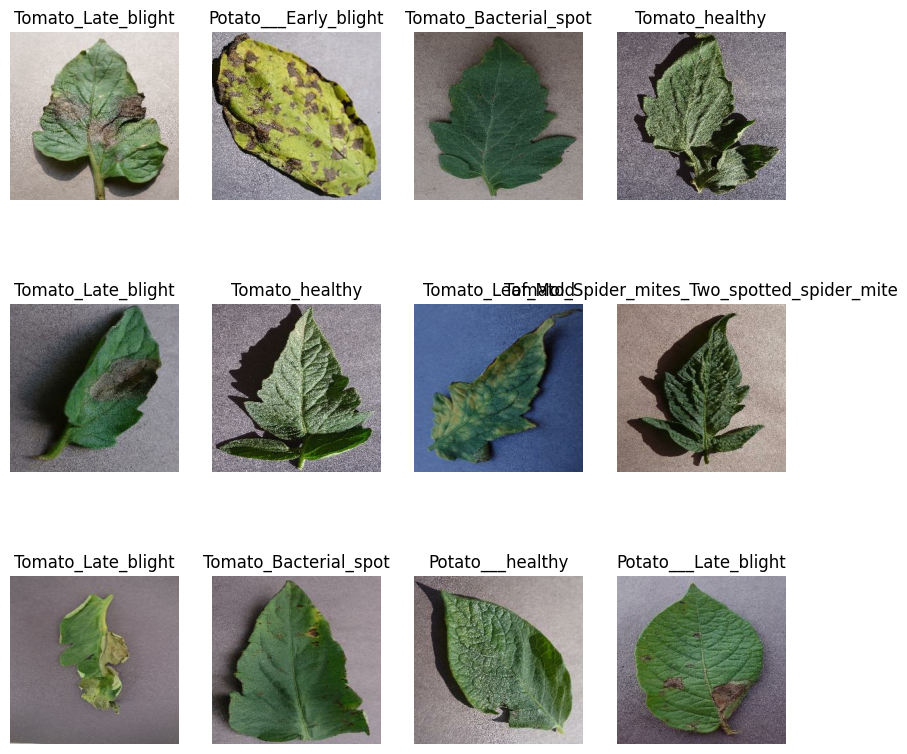

In [ ]:
plt.figure(figsize=(10, 10))
for img_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(nome_classes[labels_batch[i]])
        plt.axis("off")

### Função para dividir o Dataset
O Dataset deve ser dividio em diferentes partes, tais quais:
1. treino: Dataset utilizado no treinamento
2. validacao: Dataset utilziado enquanto é treinado o modelo
3. Test: Dataset para testar uma vez que terminou de treinar

In [ ]:
len(dataset)

323

In [ ]:
treino_tam = 0.8
len(dataset)*treino_tam

258.40000000000003

In [ ]:
treino_ds = dataset.take(258)
len(treino_ds)

258

In [ ]:
teste_ds = dataset.skip(258)
len(teste_ds)

65

In [ ]:
val_tam=0.1
len(dataset)*val_tam

32.300000000000004

In [ ]:
val_ds = teste_ds.take(32)
len(val_ds)

32

In [ ]:
teste_ds = teste_ds.skip(32)
len(teste_ds)

33

In [ ]:
def particao_dataset_tf(ds, treino_split=0.8, val_split=0.1, teste_split=0.1, shuffle=True, shuffle_tam=10000):
    assert (treino_split + teste_split + val_split) == 1

    ds_tam = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_tam, seed=12)

    treino_tam = int(treino_split * ds_tam)
    val_tam = int(val_split * ds_tam)

    treino_ds = ds.take(treino_tam)
    val_ds = ds.skip(treino_tam).take(val_tam)
    teste_ds = ds.skip(treino_tam).skip(val_tam)

    return treino_ds, val_ds, teste_ds

In [ ]:
treino_ds, val_ds, teste_ds = particao_dataset_tf(dataset)

In [ ]:
len(treino_ds)

258

In [ ]:
len(val_ds)

32

In [ ]:
len(teste_ds)

33

### Cache, Shuffle, e Prefetch no Dataset


In [ ]:
treino_ds = treino_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
teste_ds = teste_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Construção do modelo

### Criando uyma camada para ajustar o tamanho da imagem e Normalizar

Antes de alimentarmos a rede neural devemos ajustar o tamanho.
Mais ou menos, para melhorarmos o desempenho do modelo, nós deveriamos normalizar o pixel da imagens (deixando sempre no range de 0 e 1 e divindo por 256 ).
Isso deveria acontecer enquanto ocorre o treinamento tambem como possiveis interferencias. Assim também é possivel adicionar na nossa camada Sequencial.

In [ ]:
ajusta_tam_escala = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_TAM, IMG_TAM),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data augumentation é necessário quando nnós temos menos data disponivel, isso aumenta a precisão do modelo.


In [ ]:
dados_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
treino_ds = treino_ds.map(
    lambda x, y: (dados_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Arquitetura do modelo
Foi utilziado CNN junto com a ativação Softmax na camada de saída, nos também adicionamos camadas iniciais para reescalar a imagens deixala no tamanho padrão, normalização e Data Augumentation.

**Nós igemos utilizar Redes Neurais convolucionais RNC ou em inglês CNN. CNN é popular por conta de fazer muito bem a tarefa de classificar imagens.**

In [ ]:
input_forma = (BATCH_TAM, IMG_TAM, IMG_TAM, CANAIS)
n_classes = 15

modelo = models.Sequential([
    ajusta_tam_escala,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_forma),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

modelo.build(input_shape=input_forma)

In [ ]:
modelo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (64, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (64, 60, 60, 64)         

### Compilando o modelo
Estamos usando o `adam` como otimizador sendo o mesmo o mais popular e`SparseCategoricalCrossentropy` para calcular as perdas, já que se tem mais de uma classe, `Acurracy` como uma métrica que seria a "precisão"

In [ ]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
historico = modelo.fit(
    treino_ds,
    batch_size=BATCH_TAM,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
258/258 [==============================] - 158s 568ms/step - loss: 2.1783 - accuracy: 0.2828 - val_loss: 1.7406 - val_accuracy: 0.4038
Epoch 2/50
258/258 [==============================] - 138s 536ms/step - loss: 1.3755 - accuracy: 0.5411 - val_loss: 1.3390 - val_accuracy: 0.5664
Epoch 3/50
258/258 [==============================] - 138s 536ms/step - loss: 0.9003 - accuracy: 0.6957 - val_loss: 1.1160 - val_accuracy: 0.6382
Epoch 4/50
258/258 [==============================] - 138s 533ms/step - loss: 0.7096 - accuracy: 0.7533 - val_loss: 0.7229 - val_accuracy: 0.7456
Epoch 5/50
258/258 [==============================] - 138s 536ms/step - loss: 0.5721 - accuracy: 0.8045 - val_loss: 0.8543 - val_accuracy: 0.7241
Epoch 6/50
258/258 [==============================] - 137s 532ms/step - loss: 0.5064 - accuracy: 0.8224 - val_loss: 0.6703 - val_accuracy: 0.7715
Epoch 7/50
258/258 [==============================] - 139s 537ms/step - loss: 0.4412 - accuracy: 0.8461 - val_loss: 0.6771 -

In [ ]:
scores = modelo.evaluate(teste_ds)

33/33 [==============================] - 11s 39ms/step - loss: 0.2468 - accuracy: 0.9242


In [ ]:
scores

[0.24680836498737335, 0.9242424368858337]

Uma lista contendo a perda e o valor de precisão

### Plotando a precisao e as curvas de perdas no treinamento do modelo




In [ ]:
historico

você pode ver mais na documentação sobre o objeto historico ou melhor dizendo "History" da lingua inglesa e nativo da documentação: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
historico.params

{'verbose': 1, 'epochs': 50, 'steps': 258}

In [ ]:
historico.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**perda, precisao, val perda etc, são as listas python contendo os valores de perda, precisao ao final de cada  epoch**

In [ ]:
type(historico.history['loss'])

list

In [ ]:
len(historico.history['loss'])

50

In [ ]:
historico.history['loss'][:5] # show perda for first 5 epochs

[2.1783230304718018,
 1.3754748106002808,
 0.9002711772918701,
 0.7095755934715271,
 0.5720974802970886]

In [ ]:
pre = historico.history['accuracy']
val_pre = historico.history['val_accuracy']

perda = historico.history['loss']
val_perda = historico.history['val_loss']

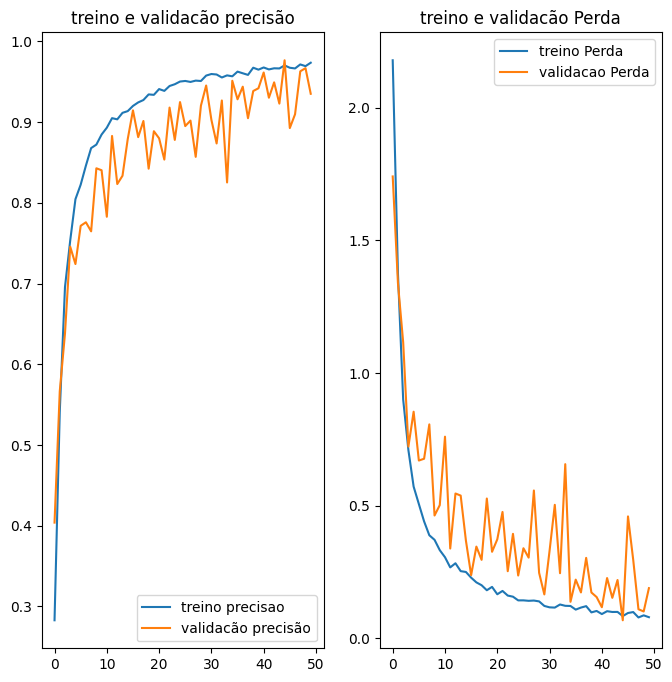

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), pre, label='treino precisao')
plt.plot(range(EPOCHS), val_pre, label='validacão precisão')
plt.legend(loc='lower right')
plt.title('treino e validacão precisão')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), perda, label='treino Perda')
plt.plot(range(EPOCHS), val_perda, label='validacao Perda')
plt.legend(loc='upper right')
plt.title('treino e validacão Perda')
plt.show()

### Rodando uma prediçaõ em uma imagem

primeira imagem pedilição
label original: Tomato_Bacterial_spot
2/2 [==============================] - 1s 12ms/step
label prevista: Tomato_Bacterial_spot


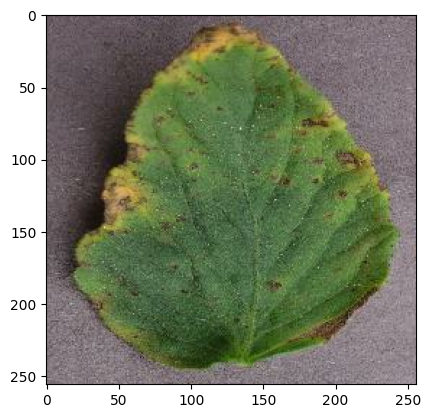

In [ ]:
import numpy as np
for img_batch, labels_batch in teste_ds.take(1):

    primeira_img = img_batch[0].numpy().astype('uint8')
    primeira_label = labels_batch[0].numpy()

    print("primeira imagem pedilição")
    plt.imshow(primeira_img)
    print("label original:",nome_classes[primeira_label])

    batch_pred = modelo.predict(img_batch)
    print("label prevista:",nome_classes[np.argmax(batch_pred[0])])


### Função para Inferência

In [ ]:
def prever(modelo, img):
    img_array = tf.keras.preprocessing.image.img_to_array(imagens[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predicoes = modelo.predict(img_array)

    classes_preditas = nome_classes[np.argmax(predicoes[0])]
    conf = round(100 * (np.max(predicoes[0])), 2)
    return classes_preditas, conf

**Rodando a função algumas imagens

1/1 [==============================] - 0s 18ms/step


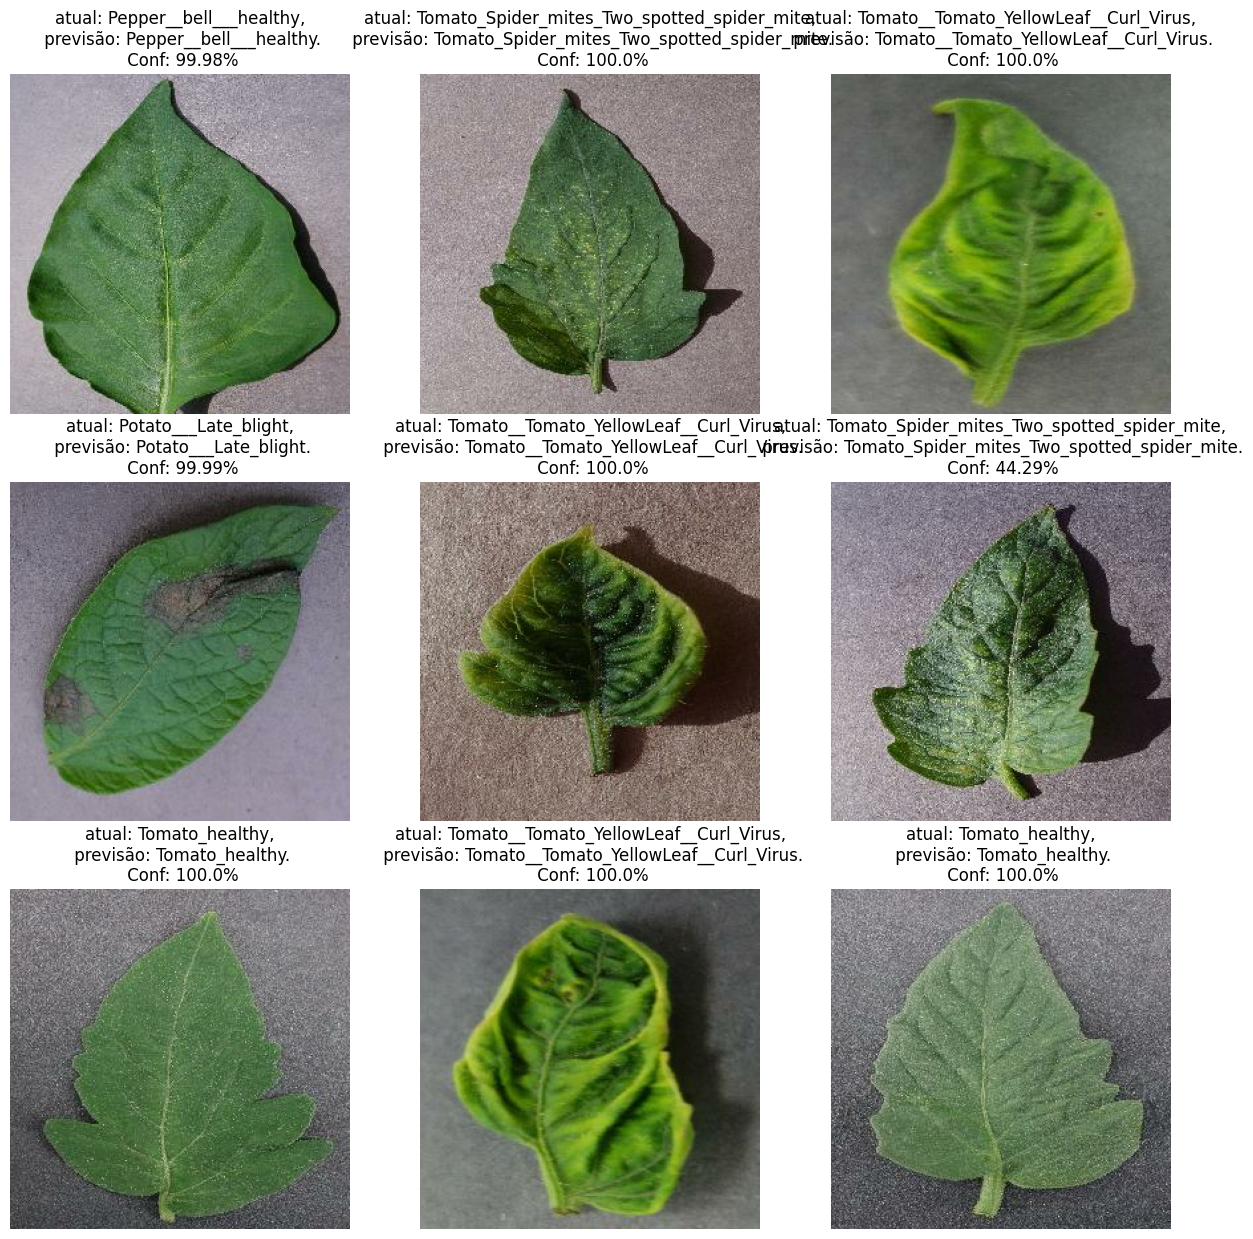

In [ ]:
plt.figure(figsize=(15, 15))
for imagens, labels in teste_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(imagens[i].numpy().astype("uint8"))

        classes_preditas, conf = prever(modelo, imagens[i].numpy())
        classe_atual = nome_classes[labels[i]]

        plt.title(f"atual: {classe_atual},\n previsão: {classes_preditas}.\n Conf: {conf}%")

        plt.axis("off")

### Salvando o modelo


In [ ]:
modelo.save(f"/content/drive/MyDrive/modelo_treinado.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modelo.save(f"/content/drive/MyDrive/modelo_treinado.keras")

In [ ]:
import os
modelo_versao=max([int(i) for i in os.listdir("../models") + [0]])+1
modelo.save(f"/content/drive/MyDrive/PlantVillage/{modelo_versao}")